## Data

In [38]:
import os
import pandas as pd
import re
from random import sample
import numpy
import seaborn as sns
import matplotlib.pyplot as plt


In [39]:

dataset_map = {
  "codenet": "CodeNet",
  "vl": "Plagiarism",
}

model_map = {
  "Gemini": "Gemini",
  "deepseek": "Deepseek-R1:8b",
  "codenet-chatgpt-1-codebert": "ChatGPT",
  "vl-2016-chatgpt-codebert": "ChatGPT"
}

embedder_map = {
  "codebert": "CodeBERT",
  "Codebert": "CodeBERT",
  "codet5p": "CodeT5+",
  "Codebert:512": "CodeBERT",
}

classifiers_map = {
  "codenet-deepseek": "CodeNet/Deepseek",
  "codenet-Gemini": "CodeNet/Gemini",
  "vl-deepseek": "Plagiarism/Deepseek",
  "vl-Gemini": "Plagiarism/Gemini",
}

In [40]:
data = pd.read_csv('../data/stats/final-scores.csv', index_col=0)
data['setting'] = data.apply(lambda row: "within" if f"{row['dataset']}-{row['llm']}" == row['classifier'] else "across", axis=1)
data_prev = pd.read_csv('../data/stats/score-apr-6.csv', index_col=0)
data_chunked = pd.read_csv('../data/stats/apr-6-chunked.csv', index_col=0)
data_embedding_size = pd.read_csv('../data/stats/embedding-length-result-on-fixed.csv', index_col=0)
data_embedding_size['embedding_size'] = data_embedding_size['embedding'].apply(lambda x: int(x.split(':')[1]))
data_embedding_size['embedding'] = data_embedding_size['embedding'].apply(lambda x: x.split(':')[0])

data_across_llm = pd.read_csv('../data/stats/across-llm-final.csv', index_col=0)


data_embedding_size_higher = pd.read_csv('../data/stats/embedding-length-result-final.csv', index_col=0)
data_embedding_size_higher['embedding_size'] = data_embedding_size_higher['embedding'].apply(lambda x: int(x.split(':')[1]))
data_embedding_size_higher['embedding'] = data_embedding_size_higher['embedding'].apply(lambda x: x.split(':')[0])

def transformVals(dataset: pd.DataFrame):
  dataset['dataset'] = dataset['dataset'].apply(lambda x: dataset_map[x])
  dataset['llm'] = dataset['llm'].apply(lambda x: model_map[x] if x in model_map else x)
  dataset['embedding'] = dataset['embedding'].apply(lambda x: embedder_map[x])
  dataset['classifier'] = dataset['classifier'].apply(lambda x: classifiers_map[x])
  return dataset

data_embedding_size = transformVals(data_embedding_size)
data_embedding_size_higher = transformVals(data_embedding_size_higher)
data_across_llm = transformVals(data_across_llm)



## Processing

In [41]:
def parseRow(row):
    row = row.strip().split("\t")
    acc = float(row[3])
    tpr = float(row[4])
    tnr = float(row[5])
    f1 = float(row[6])
    return acc, tpr, tnr, f1

def get_embedding(row):
    row = row.strip().split("\t")
    if row[2] in embedder_map:
        return embedder_map[row[2]]
    return row[2]

def get_model(row):
    row = row.strip().split("\t")
    if row[1] in model_map:
        return model_map[row[1]]
    return row[1]

def get_dataset(row):
    row = row.strip().split("\t")
    if row[0] in dataset_map:
        return dataset_map[row[0]]
    return row[0]

def get_classifier(row):
    row = row.strip().split("\t")
    return row[7]

def assembleLatexLine(dataset, languageModel, embedding, acc, tpr, tnr, f1, acc_2, tpr_2, tnr_2, f1_2):
    assembledLine = f"{dataset} \t& {languageModel} \t& {embedding} \t& {acc} & {tpr} & {tnr} & {f1} & {acc_2} & {tpr_2} & {tnr_2} & {f1_2} \\\\ \n"
    return  assembledLine

dataset_list = ['CodeNet', 'Plagiarism']
languageModel_list = ['Gemini', 'Deepseek-R1']
embedding_list = ['CodeBERT', 'CodeT5+']


In [42]:
targets_for_within = [[f"{ds}-{llm}",  ds, llm ] for ds in dataset_map.keys() for llm in model_map.keys()]


In [43]:
def limit_decimals(val):
  return f"{val:.2f}"

def build_across_stats(score_df: pd.DataFrame):
  result_str = {}
  for clf, ds, llm in targets_for_within:
    parsedRows = score_df[(score_df['classifier'] == clf) & ~(( score_df['dataset'] == ds) & (score_df['llm'] == llm))]
    prasedRowsGB = parsedRows[parsedRows['model'] == 'GradientBoosted']
    prasedRowsNN = parsedRows[parsedRows['model'] == 'NeuralNetwork']
    result_str[clf] = ""
    for row in prasedRowsGB.iterrows():
      row = row[1]
      nn_row = prasedRowsNN[(prasedRowsNN['classifier'] == row['classifier']) & (prasedRowsNN['embedding'] == row['embedding']) & (prasedRowsNN['dataset'] == row['dataset']) & (prasedRowsNN['llm'] == row['llm']) & (prasedRowsNN['model'] == 'NeuralNetwork')].iloc[0]
      result_str[clf] += assembleLatexLine(
        dataset_map[row['dataset']],
        model_map[row['llm']],
        embedder_map[row['embedding']], 
                 f"\\textbf{{{limit_decimals(row['acc'])}}}" if row['acc'] == prasedRowsGB['acc'].max() else limit_decimals(row['acc']), 
                 f"\\textbf{{{limit_decimals(row['tpr'])}}}" if row['tpr'] == prasedRowsGB['tpr'].max() else limit_decimals(row['tpr']), 
                 f"\\textbf{{{limit_decimals(row['tnr'])}}}" if row['tnr'] == prasedRowsGB['tnr'].max() else limit_decimals(row['tnr']), 
                 f"\\textbf{{{limit_decimals(row['f1'])}}}" if row['f1'] == prasedRowsGB['f1'].max() else limit_decimals(row['f1']), 
                 f"\\textbf{{{limit_decimals(nn_row['acc'])}}}" if nn_row['acc'] == prasedRowsNN['acc'].max() else limit_decimals(nn_row['acc']), 
                 f"\\textbf{{{limit_decimals(nn_row['tpr'])}}}" if nn_row['tpr'] == prasedRowsNN['tpr'].max() else limit_decimals(nn_row['tpr']), 
                 f"\\textbf{{{limit_decimals(nn_row['tnr'])}}}" if nn_row['tnr'] == prasedRowsNN['tnr'].max() else limit_decimals(nn_row['tnr']), 
                 f"\\textbf{{{limit_decimals(nn_row['f1'])}}}" if nn_row['f1'] == prasedRowsNN['f1'].max() else limit_decimals(nn_row['f1'])
                 )
  return result_str

def build_within_stats(score_df: pd.DataFrame):
  result_str_by_emb = {x: "" for x in embedder_map.keys()}
  parsedRows = score_df[
    score_df.apply(
      lambda row: any(
        (row['classifier'] == clf and row['dataset'] == ds and row['llm'] == llm)
        for clf, ds, llm in targets_for_within
      ),
      axis=1
    )
  ]  
  prasedRowsNN = parsedRows[parsedRows['model'] == 'NeuralNetwork']
  prasedRowsGB = parsedRows[parsedRows['model'] == 'GradientBoosted']
  for row in prasedRowsGB.iterrows():
    row = row[1]
    nn_row = prasedRowsNN[(prasedRowsNN['classifier'] == row['classifier']) & (prasedRowsNN['embedding'] == row['embedding']) & (prasedRowsNN['dataset'] == row['dataset']) & (prasedRowsNN['llm'] == row['llm'])].iloc[0]
    result_str_by_emb[row['embedding']] += assembleLatexLine(
      dataset_map[row['dataset']],
      model_map[row['llm']],
      embedder_map[row['embedding']], 
                f"\\textbf{{{limit_decimals(row['acc'])}}}" if row['acc'] == prasedRowsGB['acc'].max() else limit_decimals(row['acc']), 
                f"\\textbf{{{limit_decimals(row['tpr'])}}}" if row['tpr'] == prasedRowsGB['tpr'].max() else limit_decimals(row['tpr']), 
                f"\\textbf{{{limit_decimals(row['tnr'])}}}" if row['tnr'] == prasedRowsGB['tnr'].max() else limit_decimals(row['tnr']), 
                f"\\textbf{{{limit_decimals(row['f1'])}}}" if row['f1'] == prasedRowsGB['f1'].max() else limit_decimals(row['f1']), 
                f"\\textbf{{{limit_decimals(nn_row['acc'])}}}" if nn_row['acc'] == prasedRowsNN['acc'].max() else limit_decimals(nn_row['acc']), 
                f"\\textbf{{{limit_decimals(nn_row['tpr'])}}}" if nn_row['tpr'] == prasedRowsNN['tpr'].max() else limit_decimals(nn_row['tpr']), 
                f"\\textbf{{{limit_decimals(nn_row['tnr'])}}}" if nn_row['tnr'] == prasedRowsNN['tnr'].max() else limit_decimals(nn_row['tnr']), 
                f"\\textbf{{{limit_decimals(nn_row['f1'])}}}" if nn_row['f1'] == prasedRowsNN['f1'].max() else limit_decimals(nn_row['f1'])
                )
  return "".join(result_str_by_emb.values())



In [44]:
use_df = data
results_within = build_within_stats(use_df)
results_across = build_across_stats(use_df)
print(results_within)
for clf, result_str in results_across.items():
  print(f"\\textbf{{{clf}}} \n {result_str}")

CodeNet 	& Deepseek-R1:8b 	& CodeT5+ 	& 0.93 & 0.89 & 0.98 & 0.93 & 0.96 & \textbf{1.00} & 0.91 & 0.96 \\ 
CodeNet 	& Gemini 	& CodeT5+ 	& \textbf{1.00} & \textbf{1.00} & \textbf{1.00} & \textbf{1.00} & \textbf{1.00} & \textbf{1.00} & \textbf{1.00} & \textbf{1.00} \\ 
Plagiarism 	& Deepseek-R1:8b 	& CodeT5+ 	& 0.97 & 0.96 & 0.99 & 0.97 & 0.98 & 0.96 & \textbf{1.00} & 0.98 \\ 
Plagiarism 	& Gemini 	& CodeT5+ 	& 0.95 & 0.95 & 0.94 & 0.95 & 0.98 & 0.96 & \textbf{1.00} & 0.98 \\ 
CodeNet 	& Deepseek-R1:8b 	& CodeBERT 	& 0.95 & 0.94 & 0.96 & 0.95 & 0.99 & 0.99 & 0.99 & 0.99 \\ 
CodeNet 	& Gemini 	& CodeBERT 	& 0.97 & 0.95 & \textbf{1.00} & 0.97 & 0.99 & 0.99 & \textbf{1.00} & 0.99 \\ 
Plagiarism 	& Deepseek-R1:8b 	& CodeBERT 	& 0.99 & 0.98 & \textbf{1.00} & 0.99 & \textbf{1.00} & \textbf{1.00} & \textbf{1.00} & \textbf{1.00} \\ 
Plagiarism 	& Gemini 	& CodeBERT 	& 0.99 & 0.99 & 0.99 & 0.99 & \textbf{1.00} & \textbf{1.00} & \textbf{1.00} & \textbf{1.00} \\ 

\textbf{codenet-Gemini} 
 CodeNet

In [45]:
data['source'] = 'data'
data_prev['source'] = 'data_prev'
combined = pd.merge(data, data_prev, on=['dataset', 'llm', 'embedding', 'classifier', 'model'], suffixes=('_data', '_data_prev'))
combined['acc_diff'] = combined['acc_data'] - combined['acc_data_prev']
combined['tpr_diff'] = combined['tpr_data'] - combined['tpr_data_prev']
combined['tnr_diff'] = combined['tnr_data'] - combined['tnr_data_prev']
combined['f1_diff'] = combined['f1_data'] - combined['f1_data_prev']

# Drop old data columns
columns_to_drop = ['acc_data', 'tpr_data', 'tnr_data', 'f1_data', 'source_data', 
           'acc_data_prev', 'tpr_data_prev', 'tnr_data_prev', 'f1_data_prev', 'source_data_prev']
combined.drop(columns=columns_to_drop, inplace=True)
print(combined)
print(data)

    dataset       llm embedding        classifier            model  \
0   codenet  deepseek   codet5p  codenet-deepseek  GradientBoosted   
1   codenet  deepseek   codet5p  codenet-deepseek    NeuralNetwork   
2   codenet    Gemini   codet5p  codenet-deepseek  GradientBoosted   
3   codenet    Gemini   codet5p  codenet-deepseek    NeuralNetwork   
4        vl  deepseek   codet5p  codenet-deepseek  GradientBoosted   
5        vl  deepseek   codet5p  codenet-deepseek    NeuralNetwork   
6        vl    Gemini   codet5p  codenet-deepseek  GradientBoosted   
7        vl    Gemini   codet5p  codenet-deepseek    NeuralNetwork   
8   codenet  deepseek   codet5p    codenet-Gemini  GradientBoosted   
9   codenet  deepseek   codet5p    codenet-Gemini    NeuralNetwork   
10  codenet    Gemini   codet5p    codenet-Gemini  GradientBoosted   
11  codenet    Gemini   codet5p    codenet-Gemini    NeuralNetwork   
12       vl  deepseek   codet5p    codenet-Gemini  GradientBoosted   
13       vl  deepsee

## Graphs

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl


# Set IEEE-style font and figure params
mpl.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 8,
    'axes.titlesize': 9,
    'axes.labelsize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'lines.linewidth': 1.2,
    'lines.markersize': 4,
})

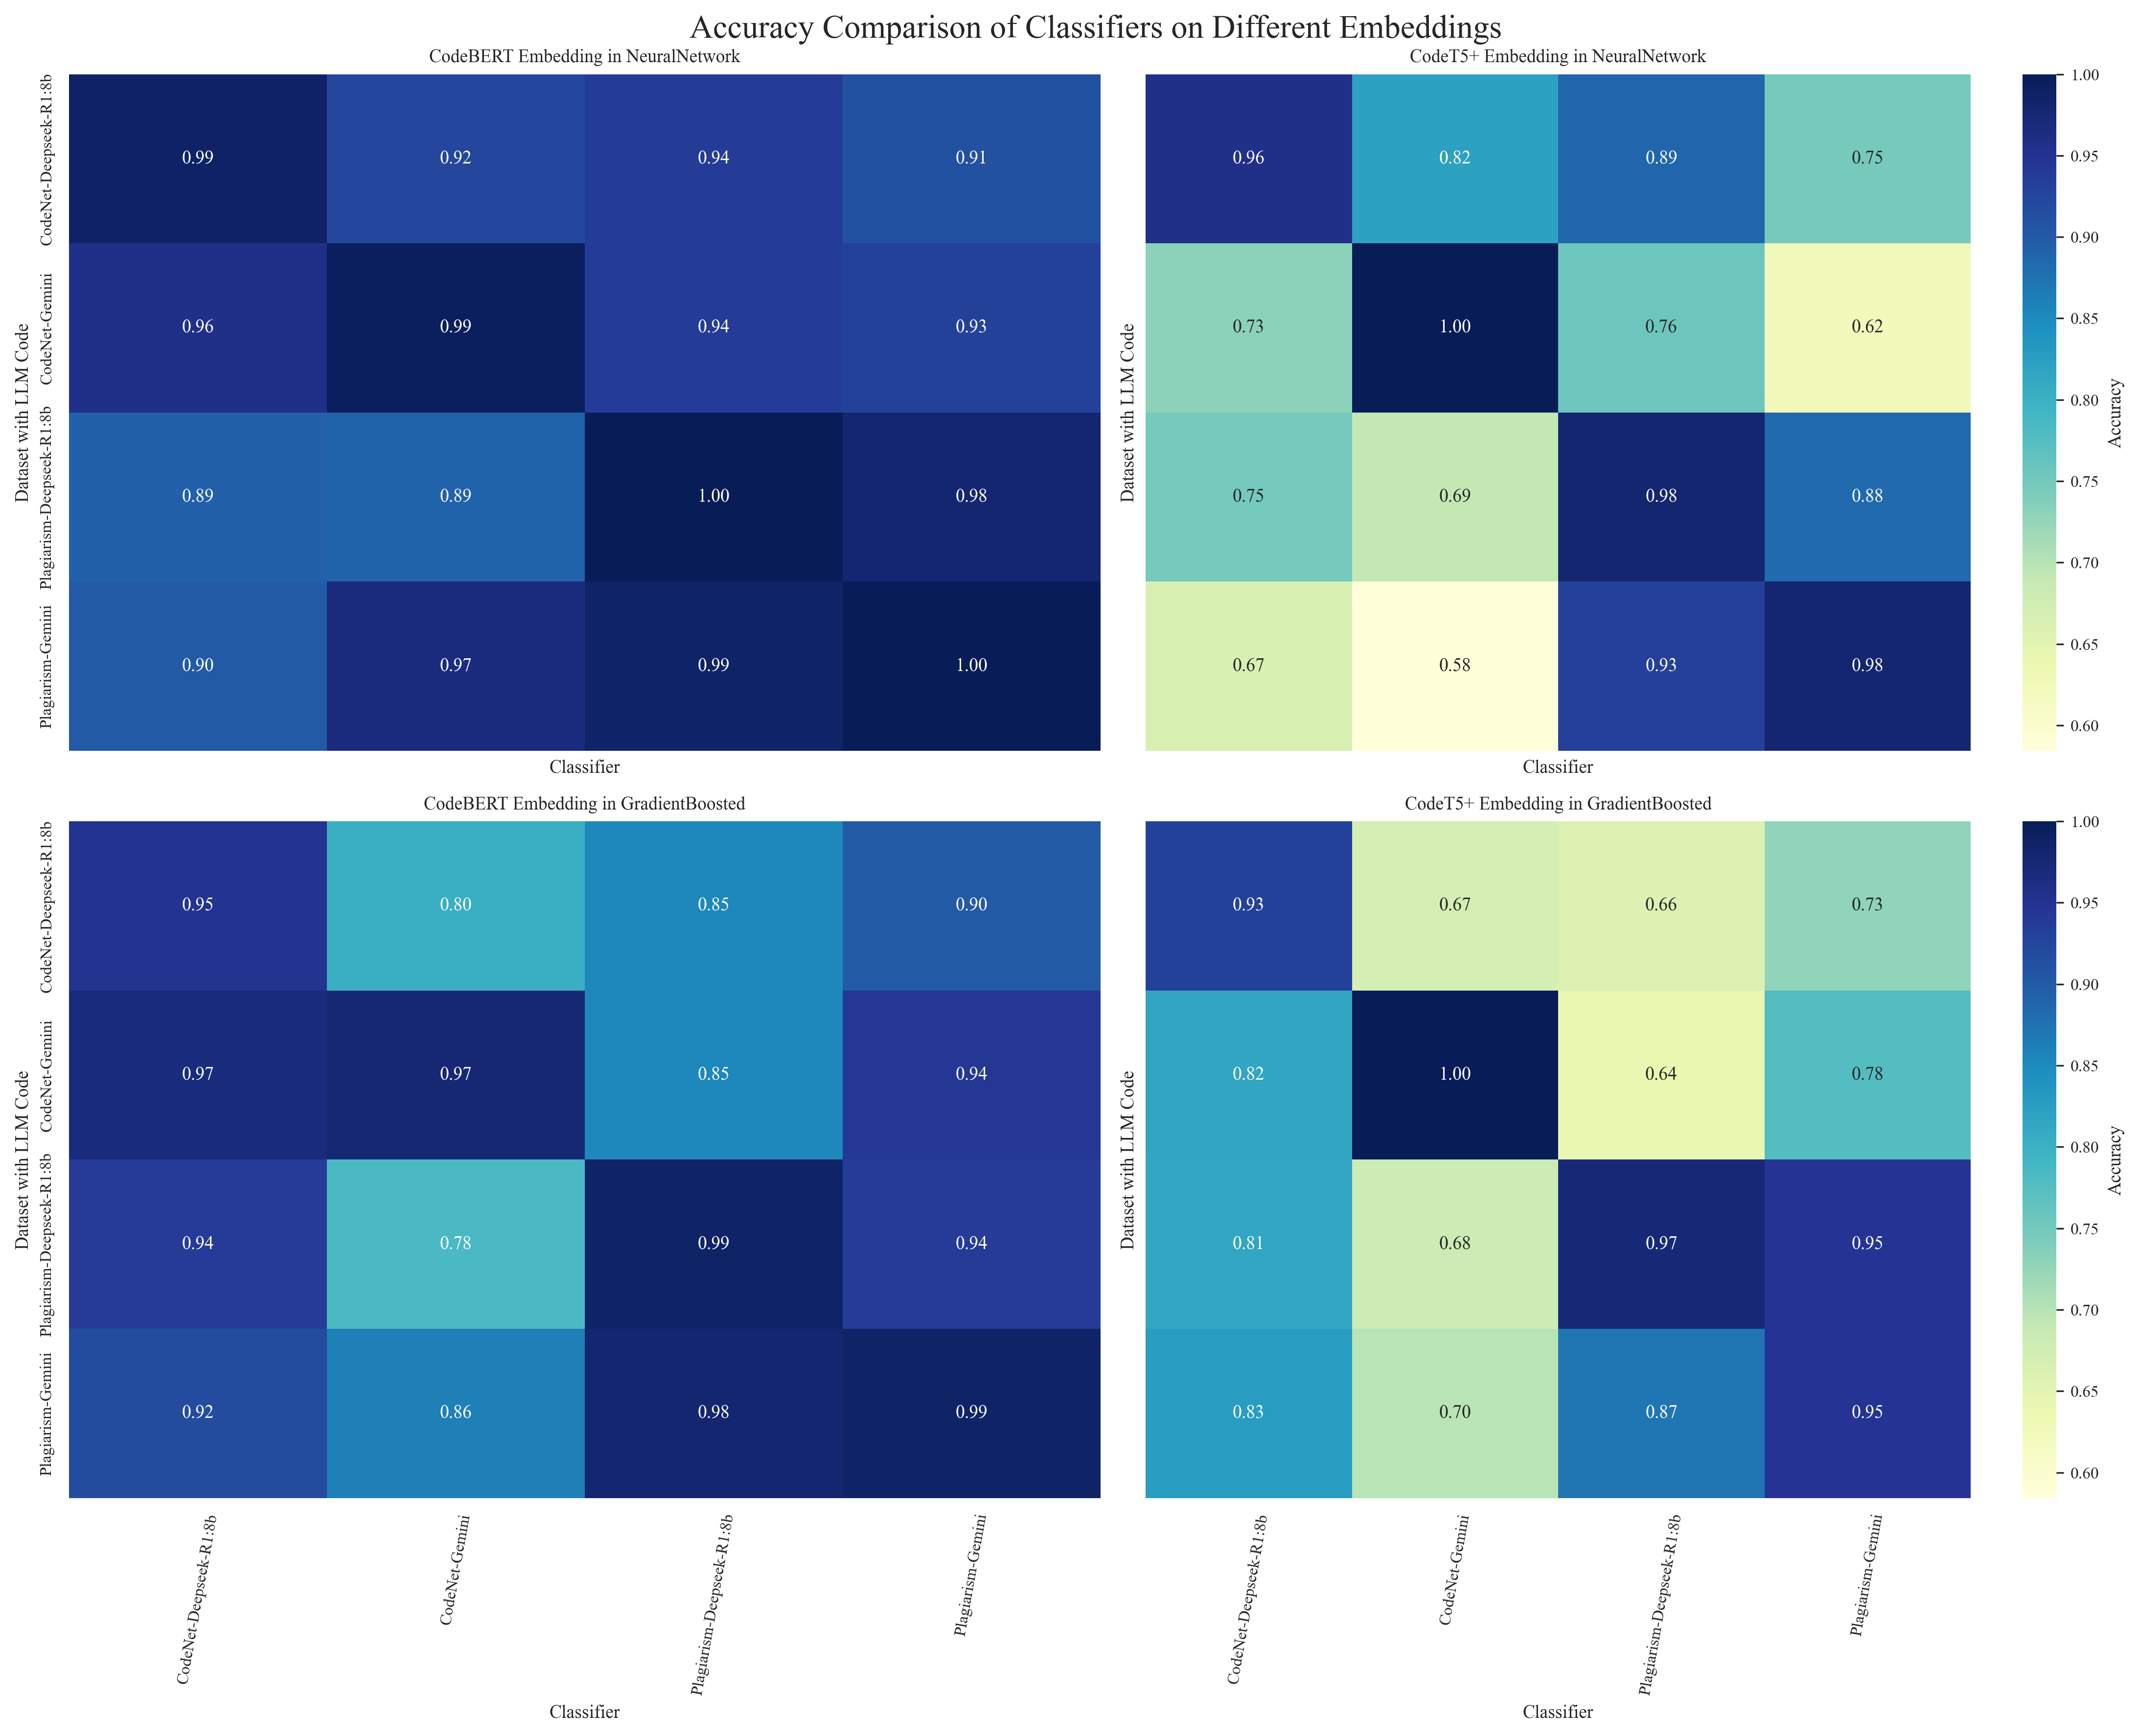

In [46]:
# plot acc
val_col = 'f1'

data_cpy = transformVals(data.copy(deep=True))
data_cpy['row'] = data_cpy['dataset'] + '-' + data_cpy['llm']
data_cpy['col'] = data_cpy['classifier']


metric_2 = ["CodeBERT", "CodeT5+"]
metric_1 = ["NeuralNetwork", "GradientBoosted"]

fig, axs = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)

# Determine the global min and max for the color scale
vmin = data_cpy[val_col].min()
vmax = data_cpy[val_col].max()

for i, metric1 in enumerate(metric_1):
    for j, metric2 in enumerate(metric_2):

        pivot = data_cpy.query(f'model == "{metric1}"').query(f'embedding == "{metric2}"').pivot(index='row', columns='col', values=val_col)
        sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Accuracy'}, ax=axs[i][j], vmin=vmin, vmax=vmax, cbar=j==1)

        axs[i][j].set_title(f"{metric2} Embedding in {metric1}")
        axs[i][j].set_xlabel('Classifier')
        axs[i][j].set_ylabel('Dataset with LLM Code')
        axs[i][j].set_xticklabels(pivot.index, rotation=80)


plt.suptitle(f"Accuracy Comparison of Classifiers on Different Embeddings", fontsize=16)
plt.tight_layout()
plt.show()


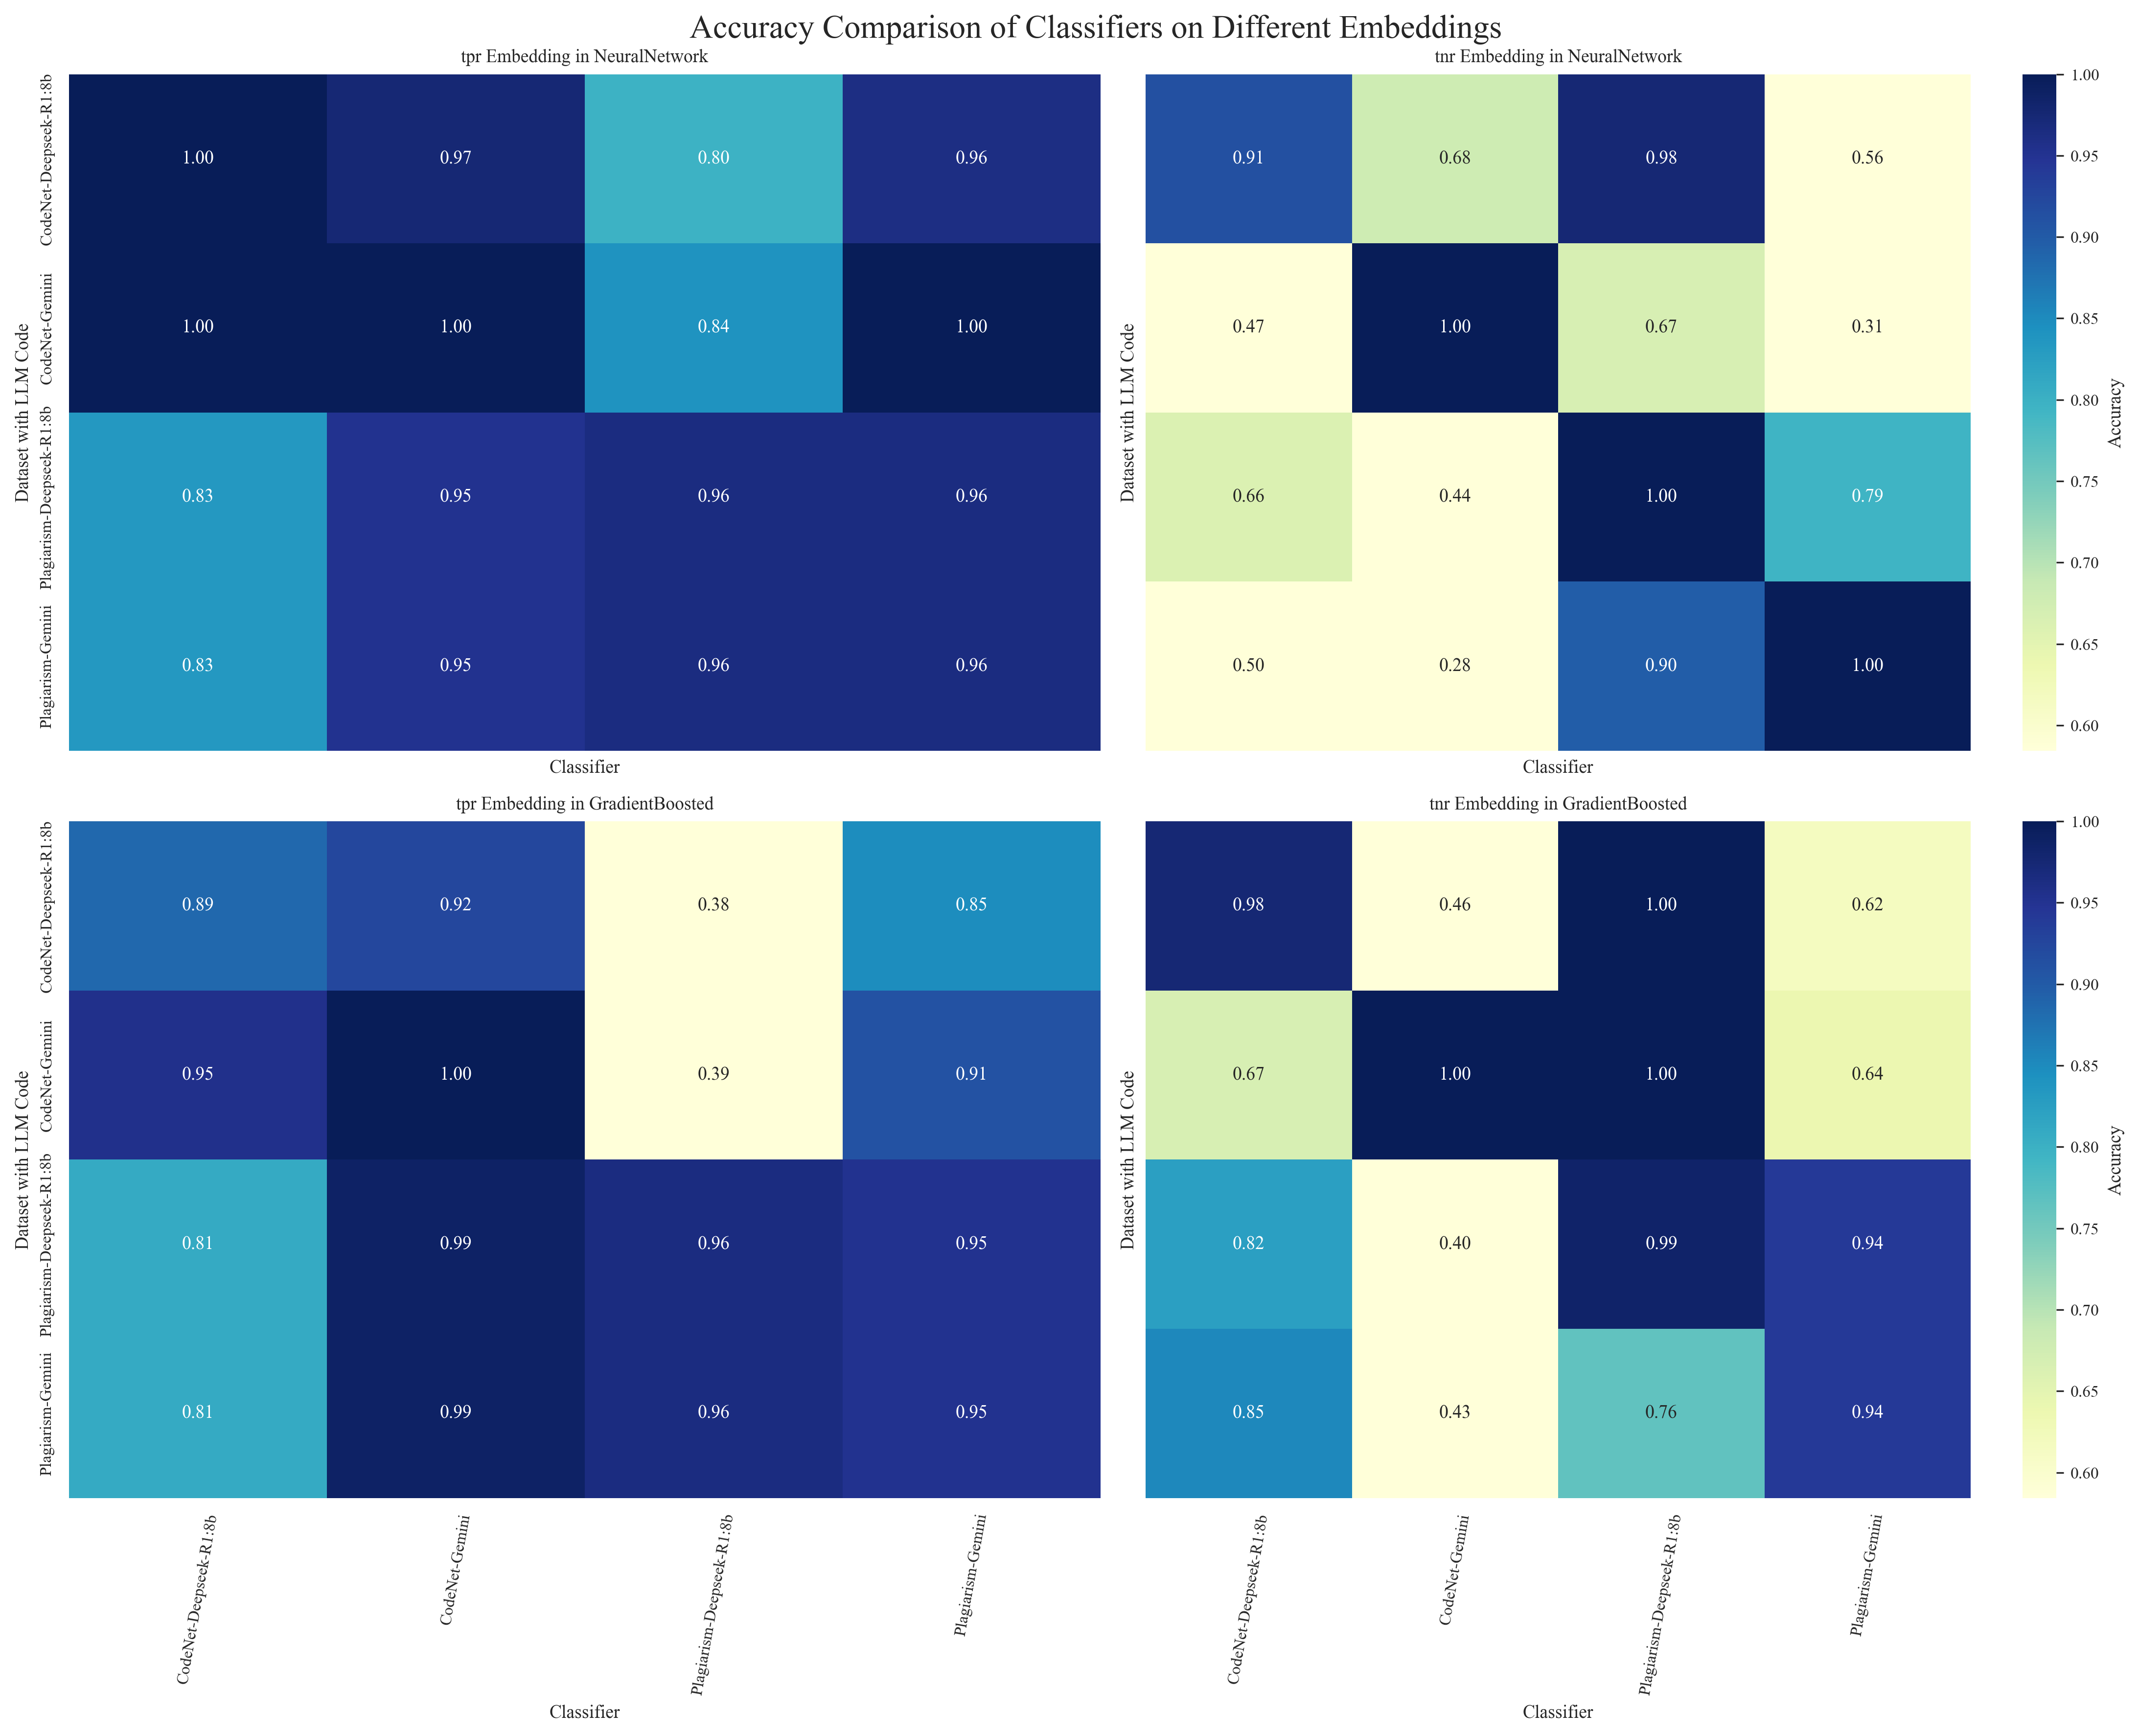

In [47]:
# plot acc

data_cpy = transformVals(data.copy(deep=True)).query('embedding == "CodeT5+"')
data_cpy['row'] = data_cpy['dataset'] + '-' + data_cpy['llm']
data_cpy['col'] = data_cpy['classifier']


metric_2 = ["tpr", "tnr"]
metric_1 = ["NeuralNetwork", "GradientBoosted"]

fig, axs = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)

# Determine the global min and max for the color scale
vmin = data_cpy[val_col].min()
vmax = data_cpy[val_col].max()

for i, metric1 in enumerate(metric_1):
    for j, metric2 in enumerate(metric_2):

        pivot = data_cpy.query(f'model == "{metric1}"').pivot(index='row', columns='col', values=metric2)
        sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Accuracy'}, ax=axs[i][j], vmin=vmin, vmax=vmax, cbar=j==1)

        axs[i][j].set_title(f"{metric2} Embedding in {metric1}")
        axs[i][j].set_xlabel('Classifier')
        axs[i][j].set_ylabel('Dataset with LLM Code')
        axs[i][j].set_xticklabels(pivot.index, rotation=80)


plt.suptitle(f"Accuracy Comparison of Classifiers on Different Embeddings", fontsize=16)
plt.tight_layout()
plt.show()


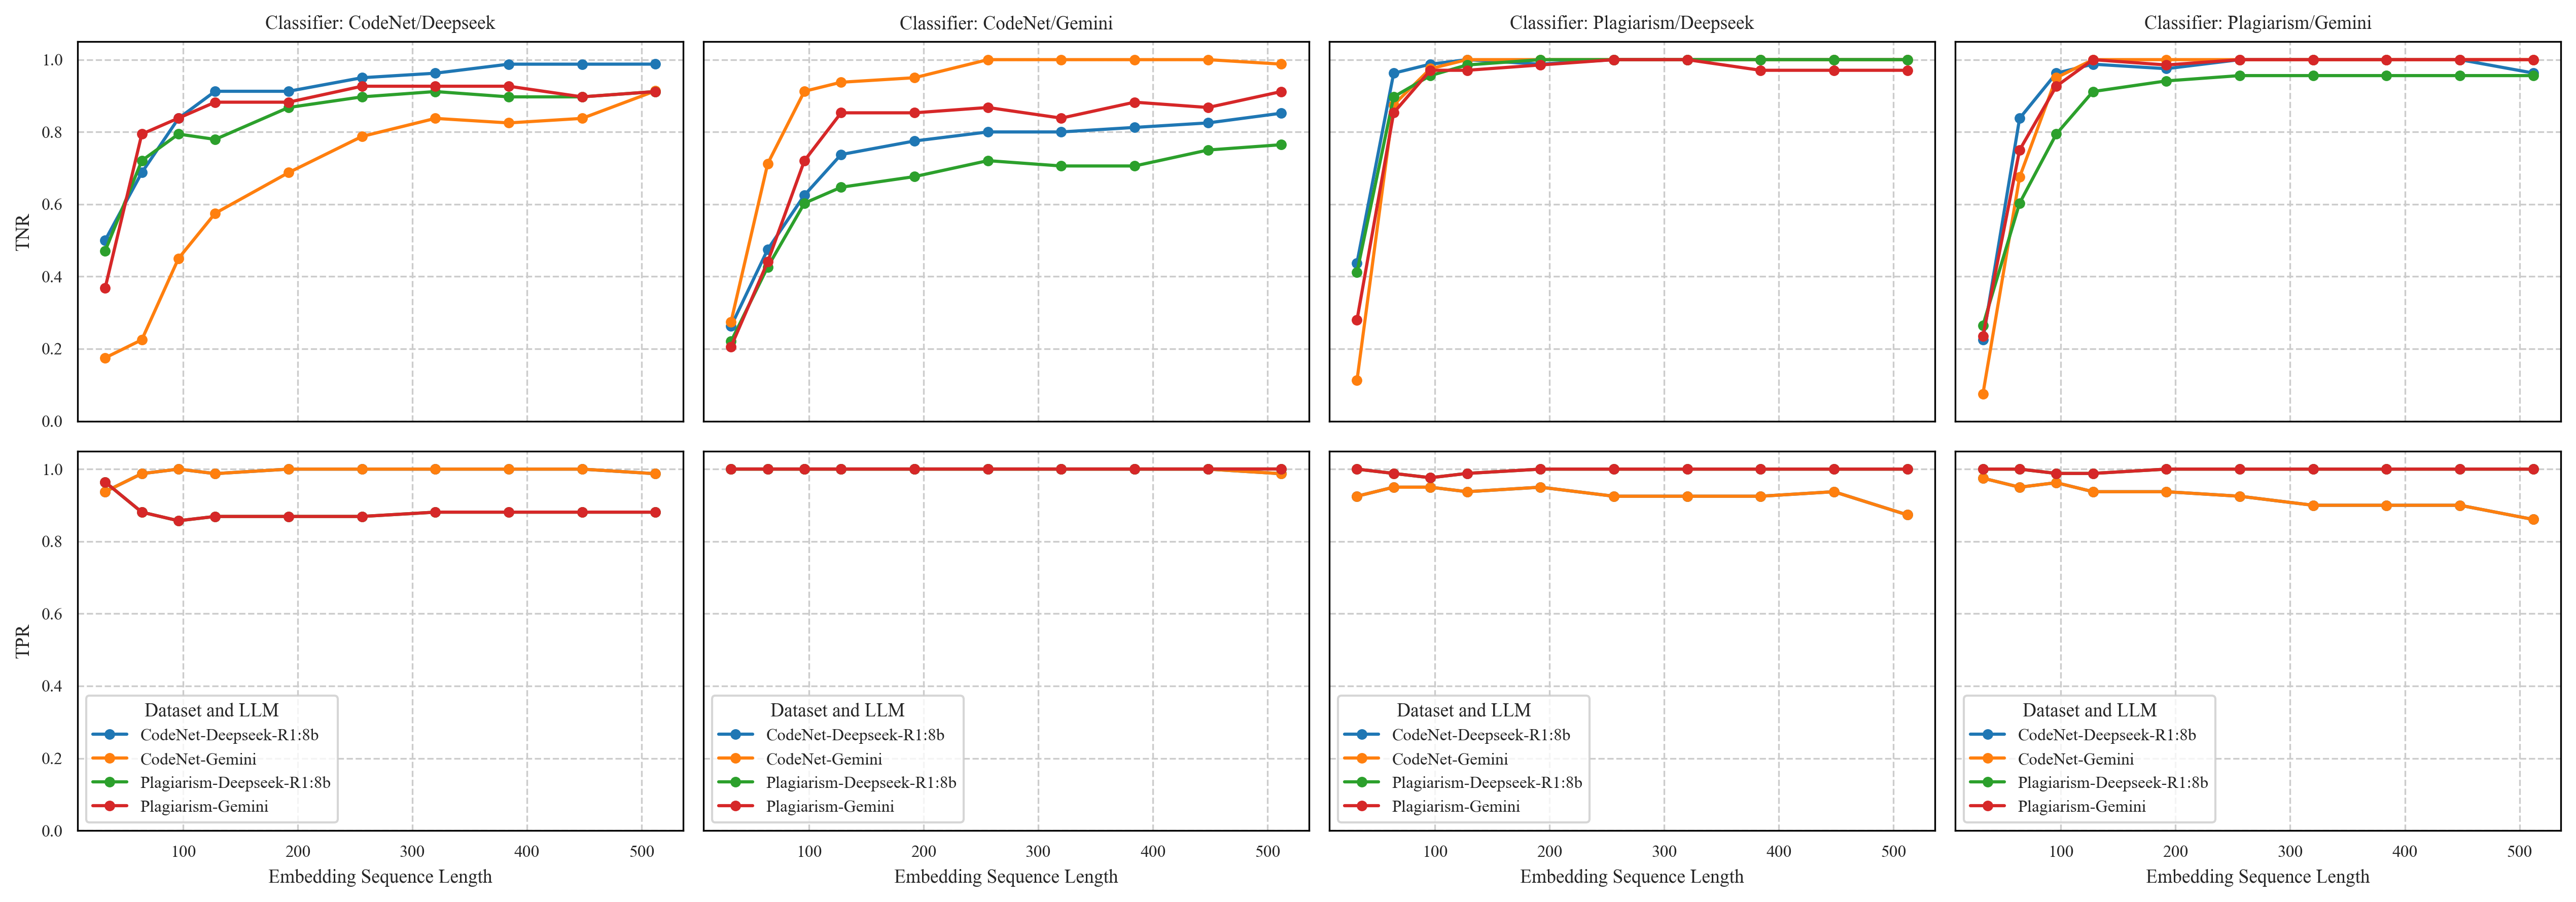

In [48]:
val_col = 'tnr'
val_2_col = 'tpr'
emb_len_data = data_embedding_size_higher.query('model == "NeuralNetwork"').copy(deep=True)

emb_len_data['row'] = emb_len_data['dataset'] + '-' + emb_len_data['llm']

fig, axs = plt.subplots(2, len(classifiers_map), figsize=(17, 6), sharex=True, sharey=True)

for i, (clf_key, clf_name) in enumerate(classifiers_map.items()):
    clf_data = emb_len_data[emb_len_data['classifier'] == clf_name]
    grouped = clf_data.groupby(['embedding_size', 'row'])[val_col].mean().unstack()
    
    # Sort the rows by embedding size numerically
    grouped = grouped.sort_index(ascending=True)
    
    grouped.plot(kind='line', ax=axs[0][i], marker='o', legend=False)
    axs[0][i].set_title(f'Classifier: {clf_name}')
    axs[0][i].set_xlabel('Embedding Size')
    axs[0][i].set_ylabel('TNR')


    grouped2 = clf_data.groupby(['embedding_size', 'row'])[val_2_col].mean().unstack()
    
    # Sort the rows by embedding size numerically
    grouped2 = grouped2.sort_index(ascending=True)

    grouped2.plot(kind='line', ax=axs[1][i], marker='o')
    axs[1][i].set_xlabel('Embedding Sequence Length')
    axs[1][i].set_ylabel('TPR')
    axs[1][i].legend(title='Dataset and LLM')

    # Adjust the y-axis to not start at 0
    axs[0][i].set_ylim(0, 1.05)

# plt.suptitle(f"TPR and TNR Comparison of Classifiers on Different Embedding Sequence Sizes, for Neural Network", fontsize=16)
plt.tight_layout()
plt.show()

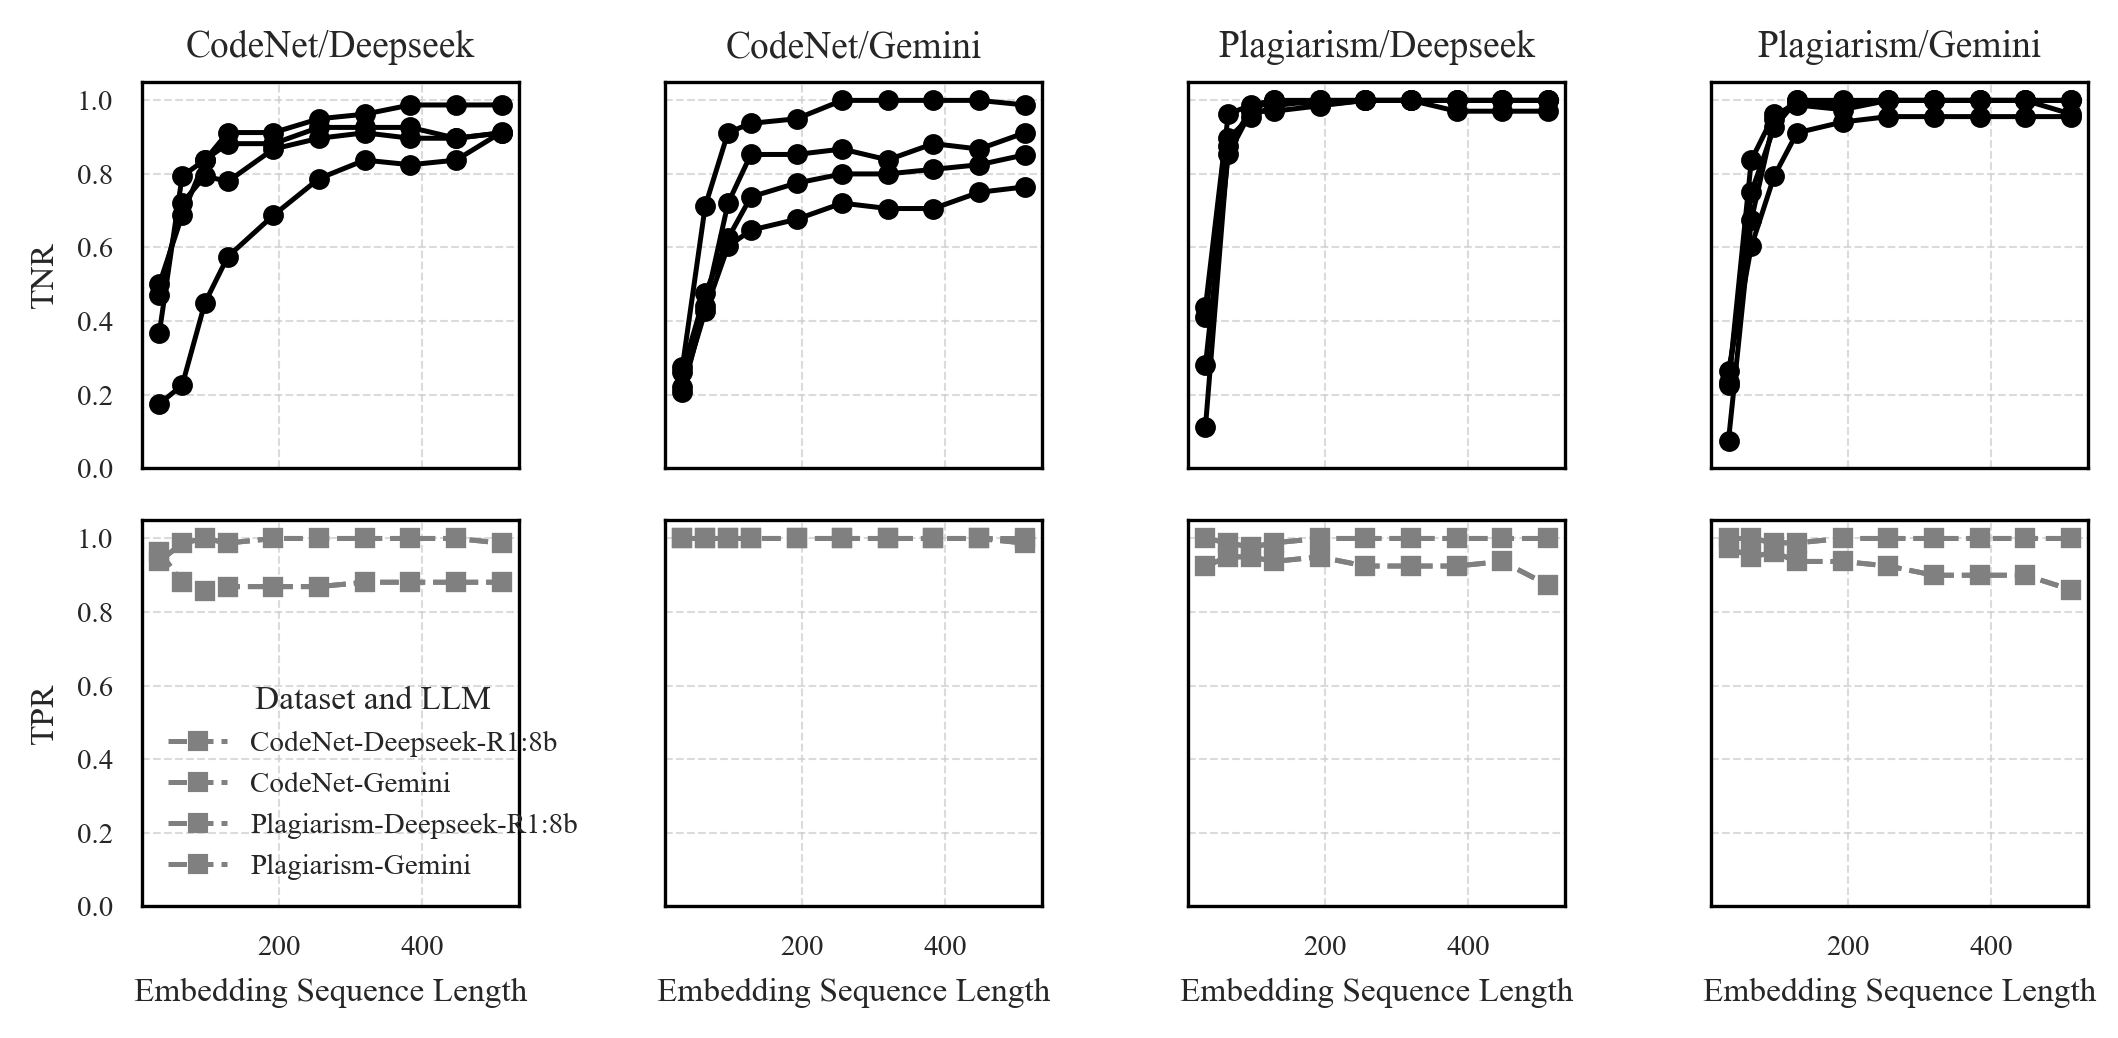

In [ ]:

val_col = 'tnr'
val_2_col = 'tpr'
emb_len_data = data_embedding_size_higher.query('model == "NeuralNetwork"').copy(deep=True)

emb_len_data['row'] = emb_len_data['dataset'] + '-' + emb_len_data['llm']

fig, axs = plt.subplots(2, len(classifiers_map), figsize=(7.1, 3.5), sharex=True, sharey=True)  # IEEE double-column width ~7.1 in
plt.subplots_adjust(wspace=0.3, hspace=0.2)

for i, (clf_key, clf_name) in enumerate(classifiers_map.items()):
    clf_data = emb_len_data[emb_len_data['classifier'] == clf_name]
    
    # Plot TNR
    grouped = clf_data.groupby(['embedding_size', 'row'])[val_col].mean().unstack()
    grouped = grouped.sort_index(ascending=True)
    grouped.plot(ax=axs[0][i], marker='o', legend=False)
    
    axs[0][i].set_ylabel('TNR')
    axs[0][i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    axs[0][i].set_ylim(0, 1.05)
    axs[0][i].set_title(f'{clf_name}', fontsize=9)

    # Plot TPR
    grouped2 = clf_data.groupby(['embedding_size', 'row'])[val_2_col].mean().unstack()
    grouped2 = grouped2.sort_index(ascending=True)
    grouped2.plot(ax=axs[1][i], marker='o')
    
    axs[1][i].set_xlabel('Embedding Sequence Length')
    axs[1][i].set_ylabel('TPR')
    axs[1][i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    axs[1][i].set_ylim(0, 1.05)

    # Only one legend in bottom-left subplot
    if i == 0:
        axs[1][i].legend(title='Dataset and LLM', loc='lower left', frameon=False)
    else:
        axs[1][i].legend().set_visible(False)

# Ensure tight layout for publication
plt.tight_layout()
plt.show()


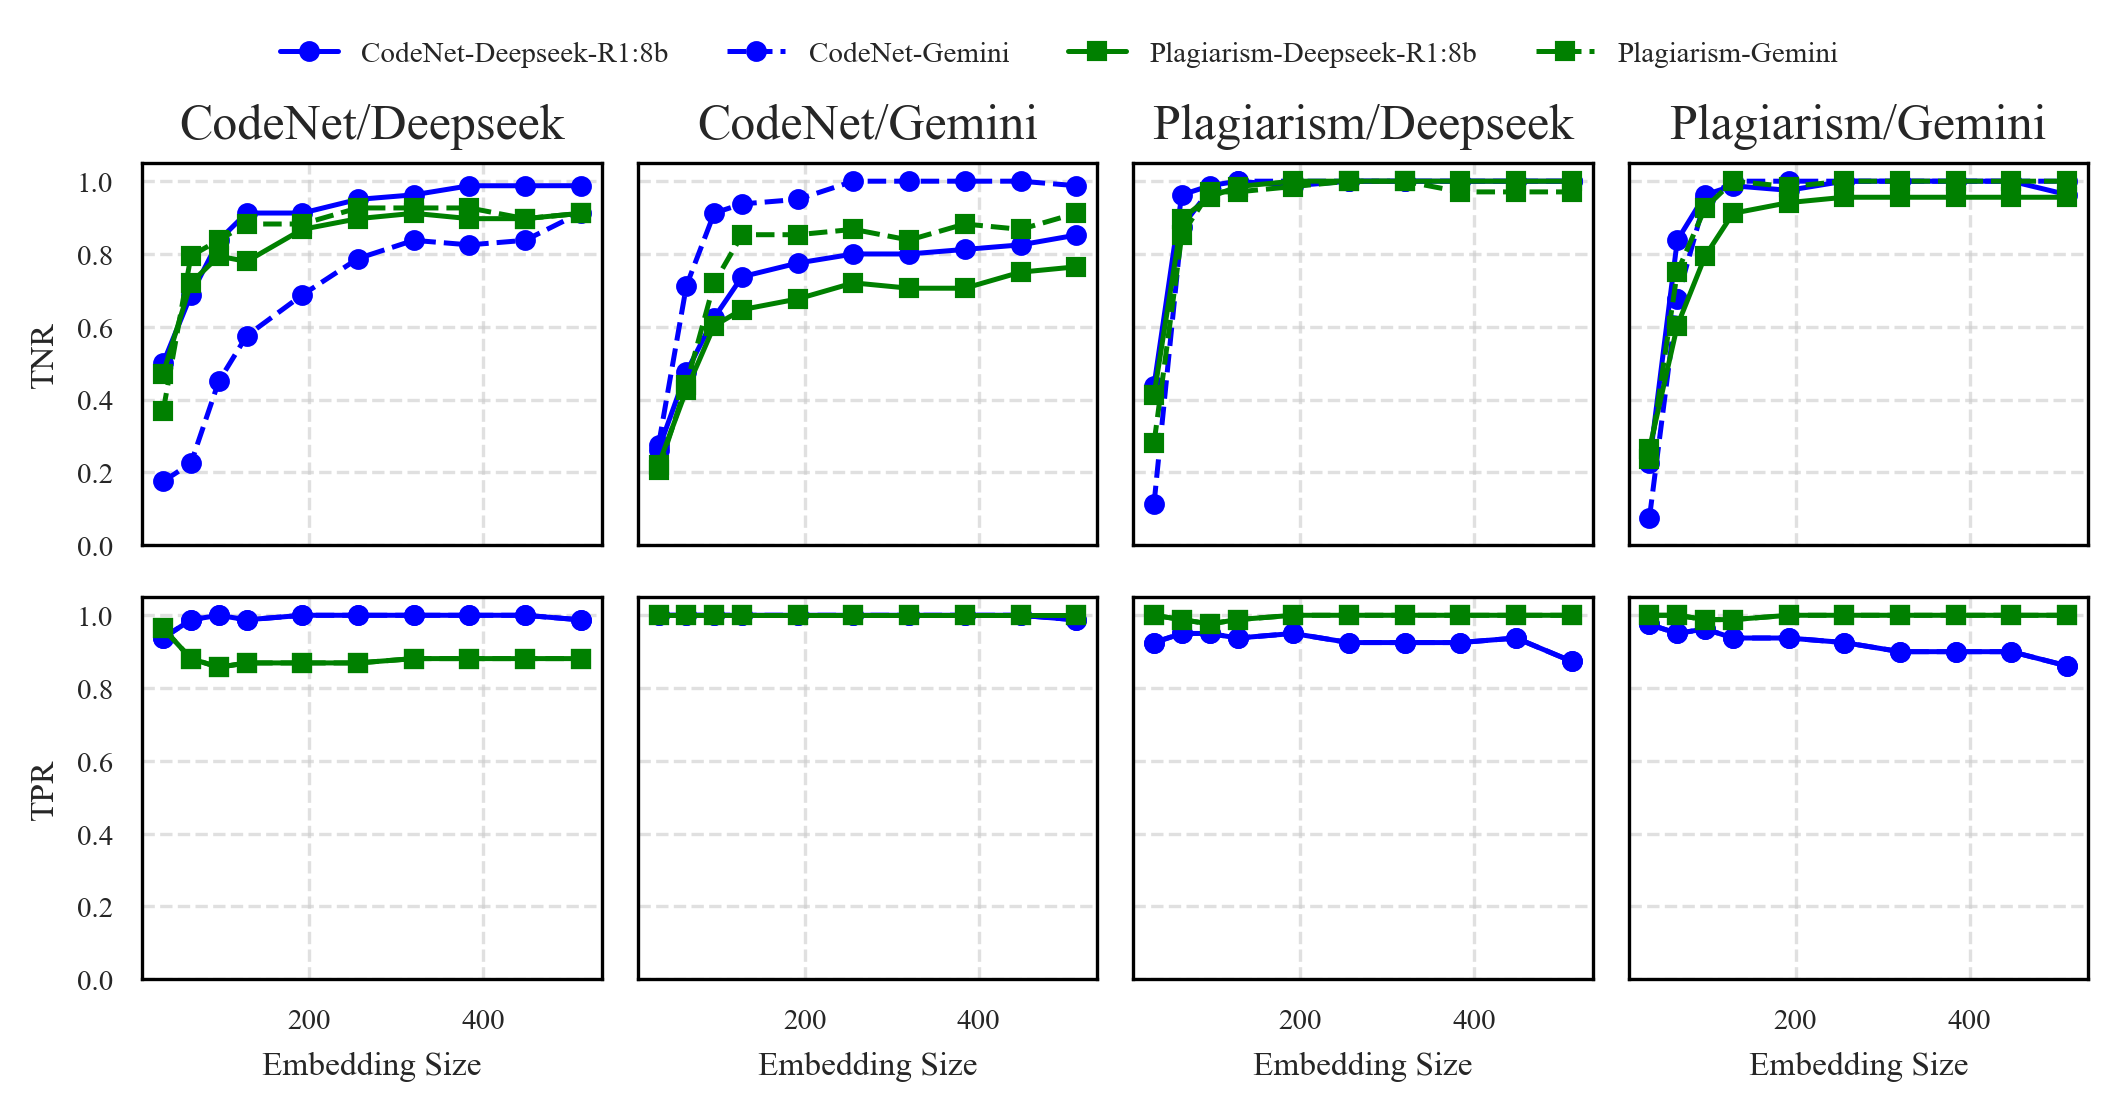

In [61]:
# Define a consistent color palette for datasets and LLMs
color_palette = {
  'CodeNet': 'blue',
  'Plagiarism': 'green'
}

llm_palette = {
  'Deepseek-R1:8b': 'orange',
  'Gemini': 'purple',
  'ChatGPT': 'red',
  'Llama': 'brown'
}

# Plot the graph
fig, axs = plt.subplots(2, len(classifiers_map), figsize=(7.1, 3.5), sharex=True, sharey=True)

for i, (clf_key, clf_name) in enumerate(classifiers_map.items()):
  clf_data = emb_len_data[emb_len_data['classifier'] == clf_name]
  
  # Plot TNR
  grouped = clf_data.groupby(['embedding_size', 'row'])[val_col].mean().unstack()
  grouped = grouped.sort_index(ascending=True)
  for row_label in grouped.columns:
    dataset_name = row_label.split('-')[0]  # Extract dataset name
    llm_name = row_label.split('-')[1]  # Extract LLM name
    grouped[row_label].plot(
      kind='line', ax=axs[0][i], marker='o' if dataset_name == 'CodeNet' else 's', legend=False,
      color=color_palette.get(dataset_name, 'gray'),
      linestyle='-' if llm_name not in llm_palette else '--',
      label=f"{dataset_name}-{llm_name}" if llm_name in llm_palette else None
    )
  axs[0][i].set_xlabel('Embedding Size')
  axs[0][i].set_ylabel('TNR')
  axs[0][i].grid(True, linestyle='--', alpha=0.6)
  axs[0][i].set_ylim(0, 1.05)  # Adjust y-axis to focus on the data range
  axs[0][i].set_title(f'{clf_name}', fontsize=12)

  # Plot TPR
  grouped2 = clf_data.groupby(['embedding_size', 'row'])[val_2_col].mean().unstack()
  grouped2 = grouped2.sort_index(ascending=True)
  for row_label in grouped2.columns:
    dataset_name = row_label.split('-')[0]  # Extract dataset name
    llm_name = row_label.split('-')[1]  # Extract LLM name
    grouped2[row_label].plot(
      kind='line', ax=axs[1][i], marker='o' if dataset_name == 'CodeNet' else 's', legend=False,
      color=color_palette.get(dataset_name, 'gray'),
      linestyle='-' if llm_name not in llm_palette else '--',
      label=f"{dataset_name}-{llm_name}" if llm_name in llm_palette else None
    )
  axs[1][i].set_xlabel('Embedding Size')
  axs[1][i].set_ylabel('TPR')
  axs[1][i].grid(True, linestyle='--', alpha=0.6)

# Add a single legend along the top
handles, labels = axs[1][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), frameon=False)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

In [ ]:
val_col = 'tnr'
emb_len_data = data_across_llm.query('model == "NeuralNetwork"')

emb_len_data['row'] = emb_len_data['dataset'] + '-' + emb_len_data['llm']

# Group data by 'row' and calculate the mean of the specified column
grouped = emb_len_data.groupby(['classifier', 'row'])[val_col].mean().unstack()

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))
grouped.plot(kind='bar', ax=ax, width=0.7)

# Set plot title and labels
# ax.set_title(f'TNR across Classifiers and Datasets with LLM Code, for Neural Network Classifiers')
ax.set_xlabel('Classifier')
ax.set_ylabel('True Negative Rate (TNR)')
ax.set_xticklabels(grouped.index, rotation=0)
ax.legend(title='Dataset with LLM Code', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.show()

C:\Users\dwang\AppData\Local\Temp\ipykernel_7564\3322121445.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emb_len_data['row'] = emb_len_data['dataset'] + '-' + emb_len_data['llm']


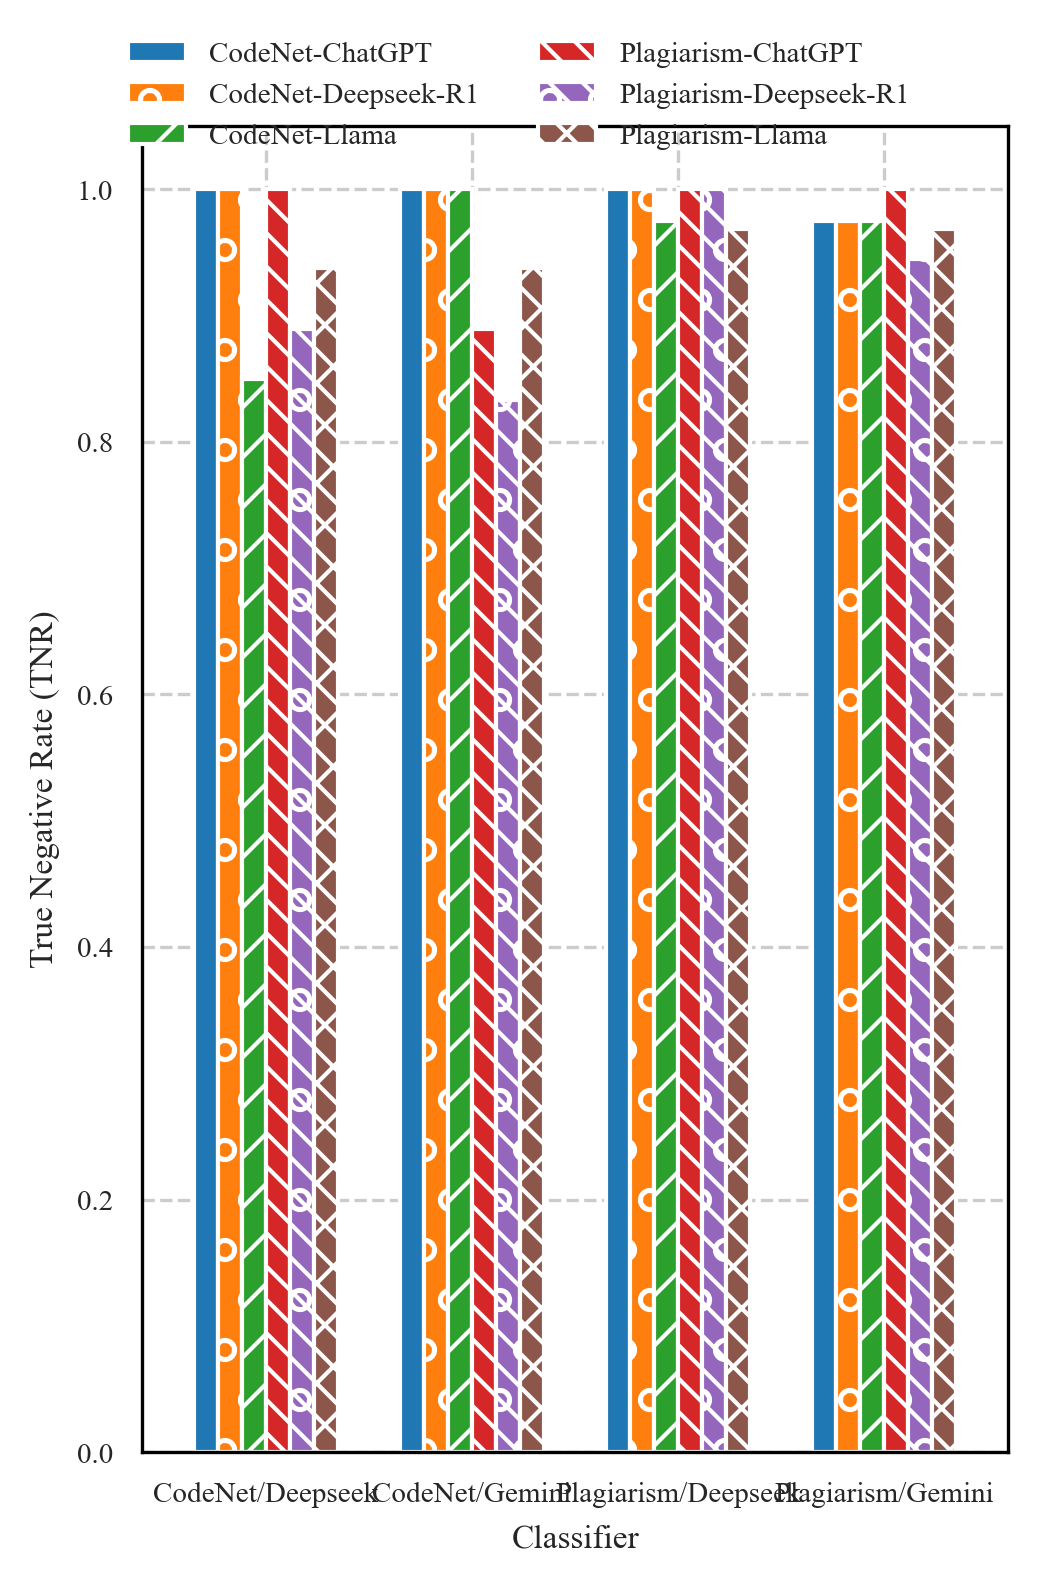

In [ ]:
val_col = 'tnr'
emb_len_data = data_across_llm.query('model == "NeuralNetwork"')

emb_len_data['row'] = emb_len_data['dataset'] + '-' + emb_len_data['llm']

# Group data by 'row' and calculate the mean of the specified column
grouped = emb_len_data.groupby(['classifier', 'row'])[val_col].mean().unstack()

# Define hatching patterns for datasets and LLMs
hatch_patterns = {
  'CodeNet': '',
  'Plagiarism': '\\\\\\',
  'ChatGPT': '',
  'Deepseek': 'o',
  'Llama': '//'
}

# Create a bar plot
fig, ax = plt.subplots(figsize=(3.5, 3.5))  # IEEE double-column width ~7.1 in

bars = grouped.plot(kind='bar', ax=ax, width=0.7, legend=False)

# Apply hatching patterns to bars
for bar_group, row_label in zip(bars.containers, grouped.columns):
  dataset = row_label.split('-')[0]  # Extract dataset name
  llm = row_label.split('-')[1]  # Extract LLM name
  hatch = hatch_patterns.get(dataset, '') + hatch_patterns.get(llm, '')
  for bar in bar_group:
    bar.set_hatch(hatch)

# Set plot title and labels
ax.set_xlabel('Classifier')
ax.set_ylabel('True Negative Rate (TNR)')
ax.set_xticklabels(grouped.index, rotation=0)

# Add a legend with hatching patterns
from matplotlib.patches import Patch

# # Create legend handles using Patch objects to support hatching and colors
# handles = [
#   Patch(
#     facecolor=llm_palette.get(llm, 'gray'), edgecolor='black', label=f'{dataset}-{llm}',
#     hatch=hatch_patterns.get(dataset, '') + hatch_patterns.get(llm, '')
#   )
#   for dataset in ['CodeNet', 'Plagiarism']
#   for llm in ['ChatGPT', 'Deepseek-R1', 'Llama']
# ]

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

C:\Users\dwang\AppData\Local\Temp\ipykernel_7564\3827090690.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emb_len_data['row'] = emb_len_data['dataset'] + '-' + emb_len_data['llm']


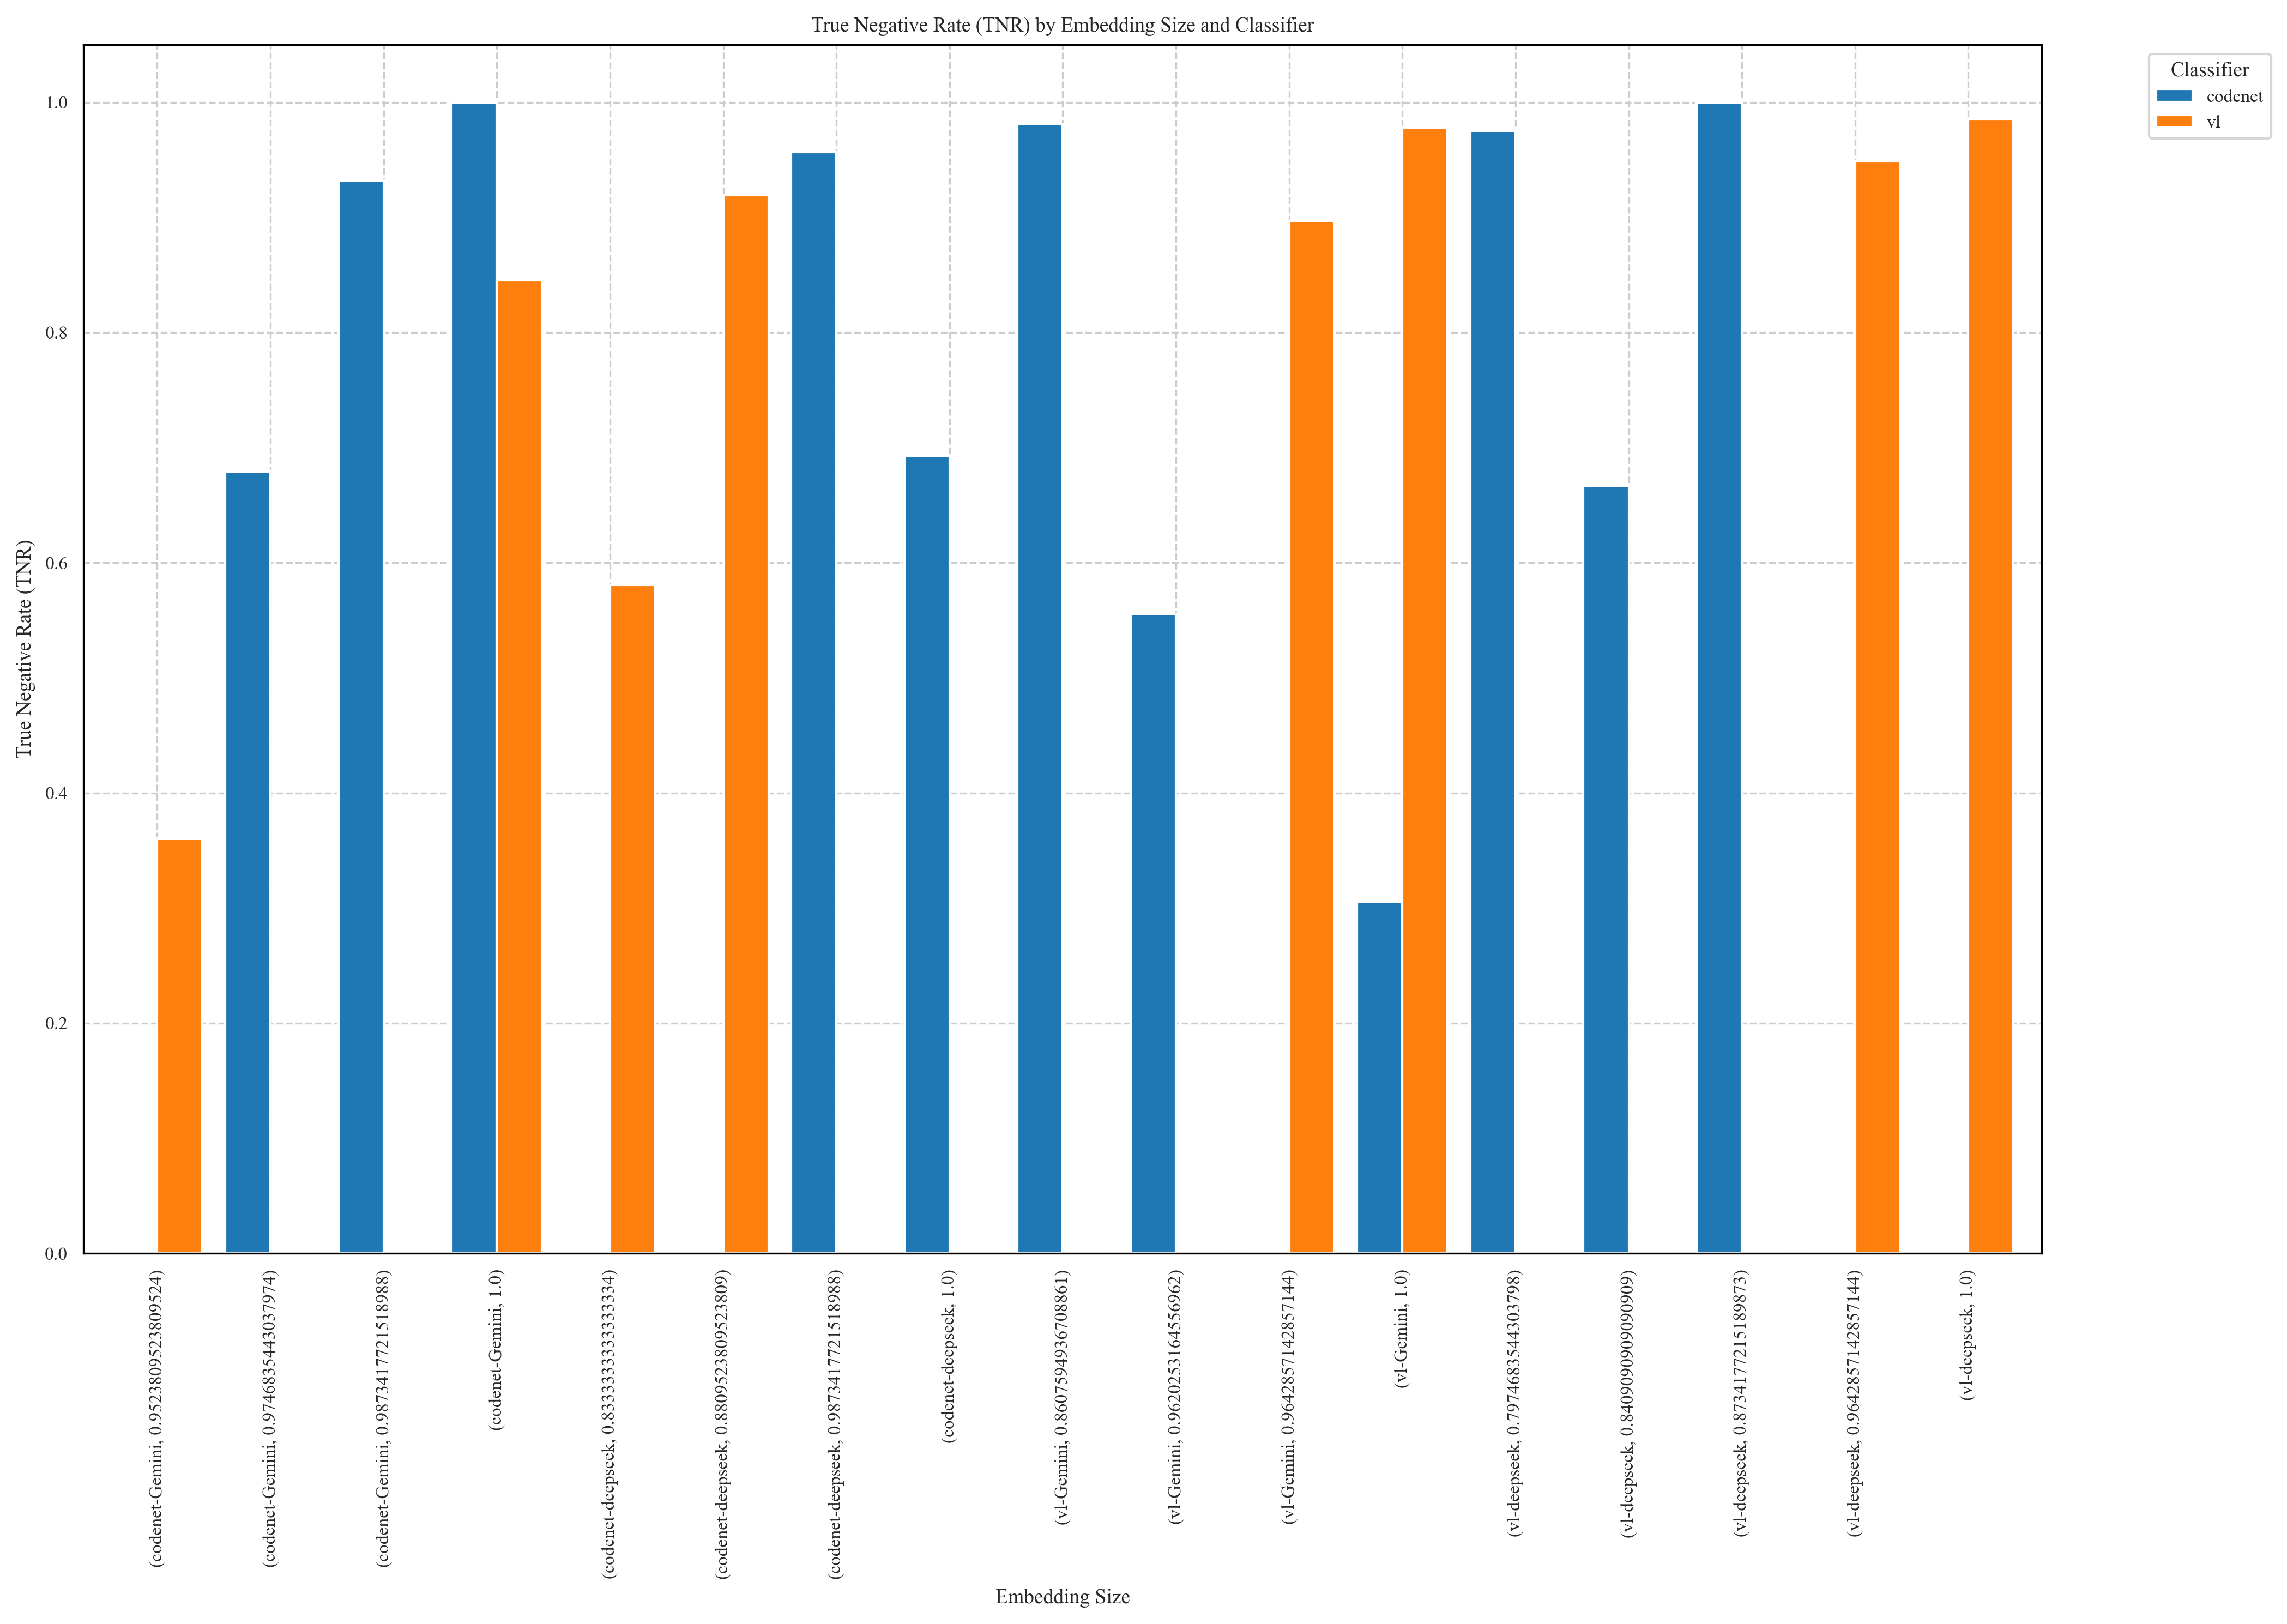

In [51]:
val_col = 'tnr'
emb_len_data = data.query('model == "NeuralNetwork"')

emb_len_data['row'] = emb_len_data['dataset'] + '-' + emb_len_data['llm']

fig, ax = plt.subplots(figsize=(14, 10))

# Group data by classifier and embedding size
grouped = emb_len_data.groupby(['classifier', 'tpr', 'dataset'])[val_col].mean().unstack()

# Create a grouped bar chart
grouped.plot(kind='bar', ax=ax, width=0.8)

# Set plot title and labels
ax.set_title('True Negative Rate (TNR) by Embedding Size and Classifier')
ax.set_xlabel('Embedding Size')
ax.set_ylabel('True Negative Rate (TNR)')
ax.legend(title='Classifier', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
